This tutorial is based on the paper of [S. M. Blinder, "Simplified Hartree-Fock Computations on Second-Row Atoms", 	arXiv:2105.07018](https://arxiv.org/abs/2105.07018)

In [1]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import cm

plt.rcParams.update({'figure.figsize': (10,6)})
plt.rcParams.update({'font.size': 12})
plt.rcParams["mathtext.fontset"] = "cm"

from scipy.optimize import minimize

# Multielectron system

System is described by the Hamiltonian operator
$$H=\sum_{i=1}^N \left\{-\frac{1}{2} \nabla_i^2-\frac{Z}{r_i}\right\} +\frac{1}{2} \sum_{i \neq j}^N \frac{1}{r_{ij}}$$.

We are interested in solving the Schrodinger equation
$$H \Psi = E \Psi$$.

To simplify the problem, we will search for the solution given by ansatz

$$\Psi(\mathbf{x}_1, \mathbf{x}_2, \ldots, \mathbf{x}_N)
  =\frac{1}{\sqrt{N!}} \text{det}\{\tilde{\psi}_1(\mathbf{r_1}) \tilde{\psi}_2(\mathbf{r_2}) ... \tilde{\psi}_N(\mathbf{r_N})\},$$
  
where $\tilde{\psi}_i(\mathbf{r_i}) = \psi_i(\mathbf{r_i}) \otimes \sigma$ is the spin orbital ($\sigma \equiv \{\alpha,\beta\}$).

Using Slater-Condon rules, we can write the energy of the system as
$$E=\langle\Psi|H|\Psi\rangle =        \sum_{i=1}^N H_i + \frac{1}{2} \sum_{i \neq j}^N (J_{ij}-K_{ij})$$

Where the matrix elements are

$$H_i = \int d^3{\bf r} \  \psi_i^*({\bf r}) \left\{-\frac{1}{2} \nabla^2  -\frac{Z}{r}\right\} \psi_i({\bf r})$$

$$J_{ij} = \int\int  d^3{\bf r} d^3{\bf r'} \ \frac{|\psi_i({\bf r})|^2 |\psi_j({\bf r'})|^2}{|{\bf r}-{\bf r'}|}$$

$$K_{ij}=
 \int\int d^3{\bf r} \ d^3{\bf r'} \  \psi_i^*({\bf r}) \psi_j^*({\bf r'}) \frac{1}{|{\bf r}-{\bf r'}|} 
 \psi_i({\bf r'}) \psi_j({\bf r}) \langle \sigma_i | \sigma_j \rangle$$

Our purpose is to find best possible one-particle wavefunctions $\psi_i(\mathbf{r_i})$ which minimize the energy of the system

$$E_{\text{min}} = \min_{\psi_1 ... \psi_N} \langle\Psi|H|\Psi\rangle $$

Therefore, we need to minimize the functional

$$E[\psi_1 ... \psi_N] = \sum_{i=1}^N H_i + \frac{1}{2} \sum_{i \neq j}^N (J_{ij}-K_{ij})$$

Let us perform real computations for the second-row atoms He through Ne, Z = 2 to 10, using the simplest set of orthonormalized 1s, 2s and 2p orbital functions.

$$\psi_{1s}=\frac{\alpha^{3/2}}{\sqrt\pi} e^{-\alpha r}$$

$$\psi_{2s}=\sqrt{\frac{3\beta^5}{\pi(\alpha^2-\alpha\beta+\beta^2)}} \left(1-\frac{\alpha+\beta}{3}r\right) e^{-\beta r}$$

$$\psi_{2p\{x,y,z\}}=\frac{\gamma^{5/2}}{\sqrt\pi} r e^{-\gamma r} \{\sin\theta \cos\phi, \sin\theta \sin\phi,\cos\theta\}$$


## Why these functions are good?

## Because the required matrix elements $H_i$, $J_{ij}$, $K_{ij}$ can be computed analytically! 

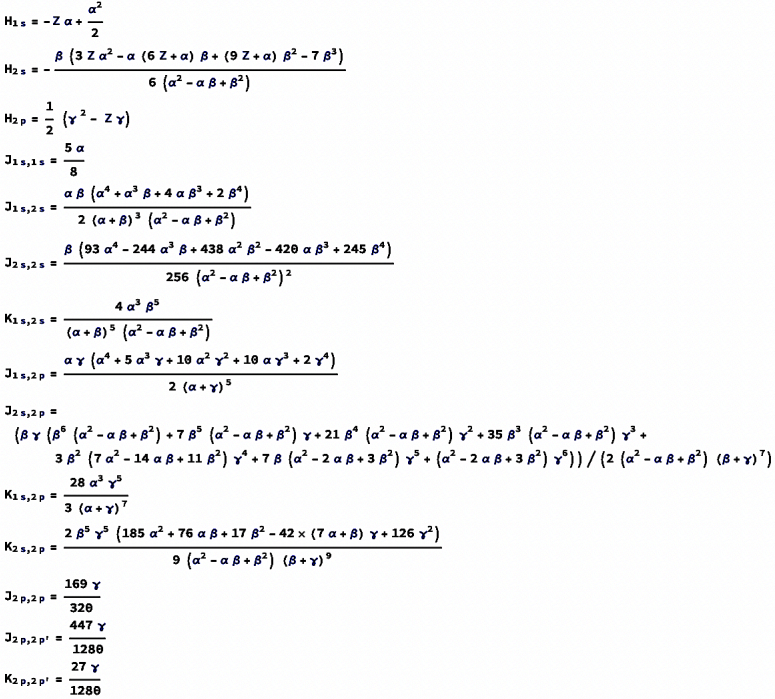

# Let us see how it works in practice!

In [2]:
class Integrals:
    def __init__(self,Z,a,b,g):
        self.__Z = Z
        self.__a = a
        self.__b = b
        self.__g = g
        
    def H(self,iorb):
        Z = self.__Z
        a = self.__a
        b = self.__b
        g = self.__g
            
        if iorb == 1:
            return -Z*a + a**2 / 2
        elif iorb == 2:
            return -b*(3*Z*a**2 - a*(6*Z+a)*b+(9*Z+a)*b**2-7*b**3)/(6*(a**2-a*b+b**2))
        elif iorb in [3,4,5]:
            return 0.5*(g**2-Z*g)
        else:
            raise RuntimeError("Wrong orbital number!")
    
    def J(self,iorb,jorb):
        Z = self.__Z
        a = self.__a
        b = self.__b
        g = self.__g
        
        if iorb == 1 and jorb == 1:
            return 5*a/8
        elif (iorb == 1 and jorb == 2) or (iorb == 2 and jorb == 1):
            return a*b*(a**4+a**3*b+4*a*b**3+2*b**4)/(2*(a+b)**3*(a**2-a*b+b**2))
        elif iorb == 2 and jorb == 2:
            return b*(93*a**4-244*a**3*b+438*a**2*b**2-420*a*b**3+245*b**4)/(256*(a**2-a*b+b**2)**2)
        elif (iorb == 1 and jorb in [3,4,5]) or (iorb in [3,4,5] and jorb == 1):
            return a*g*(a**4+5*a**3*g+10*a**2*g**2+10*a*g**3+2*g**4)/(2*(a+g)**5)
        elif (iorb == 2 and jorb in [3,4,5]) or (iorb in [3,4,5] and jorb == 2):
            return b*g*(b**6*(a**2-a*b+b**2)+7*b**5*(a**2-a*b+b**2)*g+21*b**4*(a**2-a*b+b**2)*g**2+35*b**3*(a**2-a*b+b**2)*g**3\
                  +3*b**2*(7*a**2-14*a*b+11*b**2)*g**4+7*b*(a**2-2*a*b+3*b**2)*g**5+(a**2-2*a*b+3*b**2)*g**6)/\
                  (2*(a**2-a*b+b**2)*(b+g)**7)
        elif iorb in [3,4,5] and jorb in [3,4,5]:
            if iorb == jorb:
                return 169*g/320
            else:
                return 447*g/1280
        else:
            print(iorb,jorb)
            raise RuntimeError("Wrong orbital number!")
    
    def K(self,iorb,jorb):
        Z = self.__Z
        a = self.__a
        b = self.__b
        g = self.__g
        
        if iorb == jorb and iorb >= 1 and iorb <= 5:
            return self.J(iorb,jorb)
        elif (iorb == 1 and jorb == 2) or (iorb == 2 and jorb == 1):
            return 4*a**3*b**5/((a+b)**5*(a**2-a*b+b**2))
        elif (iorb == 1 and jorb in [3,4,5]) or (iorb in [3,4,5] and jorb == 1):
            return 28*a**3*g**5/(3*(a+g)**7)
        elif (iorb == 2 and jorb in [3,4,5]) or (iorb in [3,4,5] and jorb == 2):
            return 2*b**5*g**5*(185*a**2+76*a*b+17*b**2-42*(7*a+b)*g+126*g**2)/(9*(a**2-a*b+b**2)*(b+g)**9)
        elif iorb in [3,4,5] and jorb in [3,4,5]:
            return 27*g/1280
        else:
            raise RuntimeError("Wrong orbital number!")

## We construct the spin orbitals taking into account Pauli principle and Hund rule

$$1s^2 2s^2 2p^6 ...$$

In [3]:
SOs_all = [
    [1,+1/2],[1,-1/2],
    [2,+1/2],[2,-1/2],
    [3,+1/2],[4,+1/2],[5,+1/2],
    [3,-1/2],[4,-1/2],[5,-1/2]
]

We define a simple python function which computes energy of the system by taking number of electrons ($N=Z$) and values of parameters $\alpha$, $\beta$, $\gamma$ as an input 

In [4]:
def Energy(params,Z,progress):
    a = params[0]
    b = params[1]
    g = params[2]

    intgr = Integrals(Z,a,b,g)
    
    SOs = SOs_all[:Z]

    en = 0

    for orb in SOs:
        i = orb[0]
        en += intgr.H(i)

    for iorb in SOs:
        for jorb in SOs:
            i = iorb[0]
            j = jorb[0]
            si = iorb[1]
            sj = jorb[1]

            Jij = intgr.J(i,j)
            Kij = 0.0
            if si == sj:
                Kij = intgr.K(i,j)

            en += 0.5*(Jij-Kij)    

    progress.append(en)

    return en

# Let us see how it works!

In [7]:
#Helium atom
Z = 2
params = np.random.rand(3)  #some random parameters of the orbitals

#compute energy!
E_He = Energy(params,Z,[])

print(params)
print(E_He)

[0.15393572 0.40641066 0.88191951]
-0.49583683978165705


## What do we want to obtain?
https://physics.nist.gov/PhysRefData/ASD/ionEnergy.html
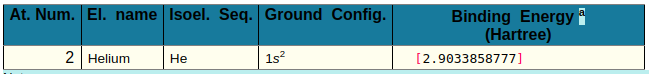

## We can do optimization to find best values of parameters

In [8]:
params0 = [0.4,  0.0,  0.0]
Z = 2

progress = []
res = minimize(Energy,params0,args=(Z,progress),method='COBYLA',options={'maxiter': 30, 'disp': True})

print(res)

     fun: -2.8476557599354
   maxcv: 0.0
 message: 'Maximum number of function evaluations has been exceeded.'
    nfev: 30
  status: 2
 success: False
       x: array([ 1.68679995,  0.        , -0.11727829])
   Return from subroutine COBYLA because the MAXFUN limit has been reached.

   NFVALS =   30   F =-2.847656E+00    MAXCV = 0.000000E+00
   X = 1.686800E+00   0.000000E+00  -1.172783E-01



# We can visualize the progress!

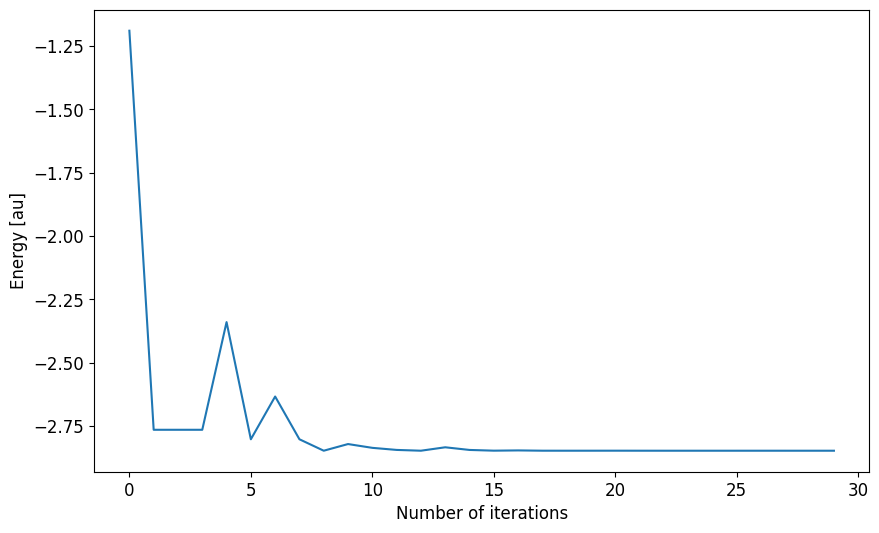

In [9]:
plt.plot(progress);
plt.xlabel('Number of iterations');
plt.ylabel('Energy [au]');

## Our model orbitals (1s, 2s, 2p) allow us to compute elements up to Ne (Z=10)!

In [10]:
#params0 = np.random.rand(3)
params0 = [0.85, 0.35, 0.35]

energies_t = []

for Z in range(1,11):
    res = minimize(Energy,params0,args=(Z,[]),method='COBYLA')
    optimal_params = res.x
    E = Energy(optimal_params,Z,[])
    energies_t.append(E)
    
    print("Z = %2.d, E = %10.5f" % (Z,E))

Z =  1, E =   -0.50000
Z =  2, E =   -2.84766
Z =  3, E =   -7.41385
Z =  4, E =  -14.53001
Z =  5, E =  -24.45061
Z =  6, E =  -37.54713
Z =  7, E =  -54.15975
Z =  8, E =  -74.09474
Z =  9, E =  -98.06856
Z = 10, E = -123.30206


## How good is our model?

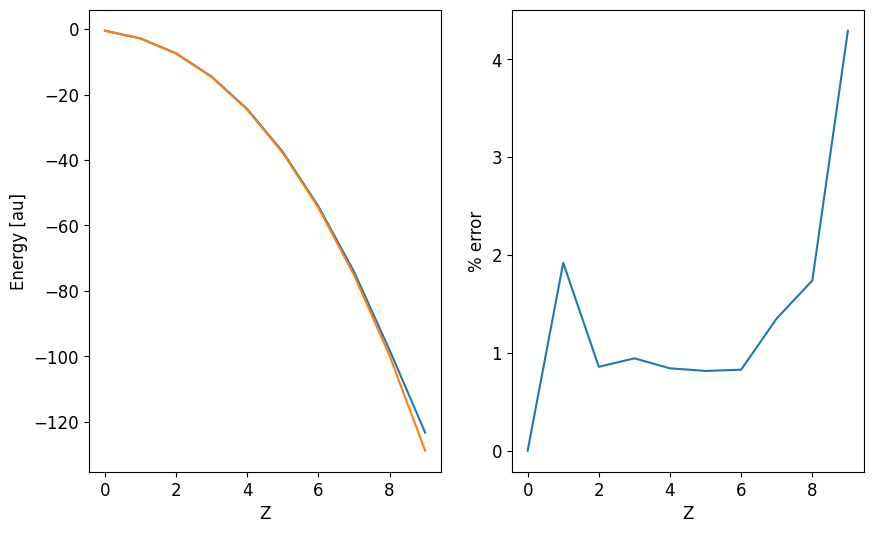

In [11]:
energies_NIST = np.asarray([-0.5,-2.903385,-7.477976,-14.668449,-24.658211,-37.855668,-54.611893,-75.109991,-99.803888,-128.830462])
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(energies_t); ax1.plot(energies_NIST);
ax1.set_xlabel('Z'); ax1.set_ylabel('Energy [au]');
ax2.plot((energies_NIST-energies_t)/energies_NIST*100);
ax2.set_xlabel('Z'); ax2.set_ylabel('% error');

# Can Hartree-Fock do better?

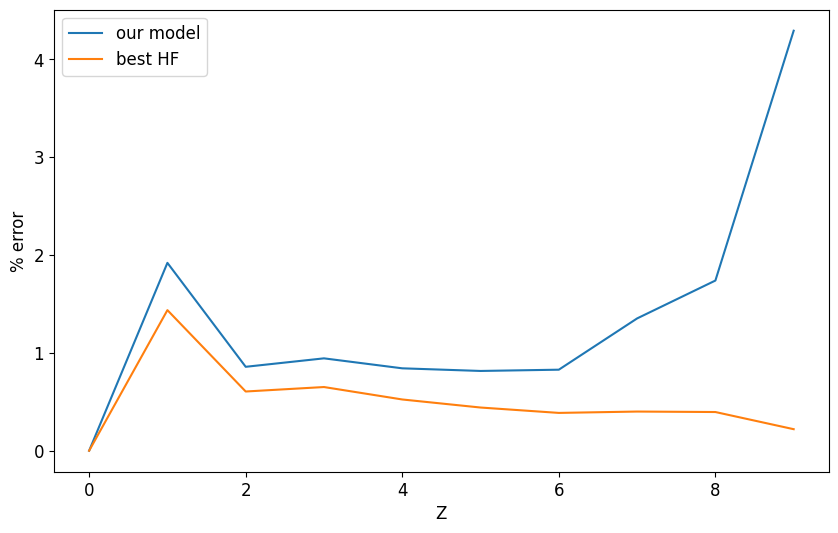

In [12]:
energies_best=[-0.5,-2.86168,-7.43273,-14.5730,-24.5291,-37.6886,-54.4009,-74.8094,-99.4093,-128.547]
plt.plot((energies_NIST-energies_t)/energies_NIST*100,label='our model');
plt.plot((energies_NIST-energies_best)/energies_NIST*100,label='best HF');
plt.xlabel('Z'); plt.ylabel('% error');
plt.legend(loc="upper left")

# Hartree-Fock-Roothaan method

In [13]:
from pyscf import scf, gto

system = gto.M(atom = 'He 0 0 0', basis = 'ccpvdz', spin=0)
HF = scf.UHF(system)
HF.verbose = 3

energy = HF.run()

converged SCF energy = -2.85516047724274  <S^2> = -4.4408921e-16  2S+1 = 1


basis sets: https://www.basissetexchange.org/

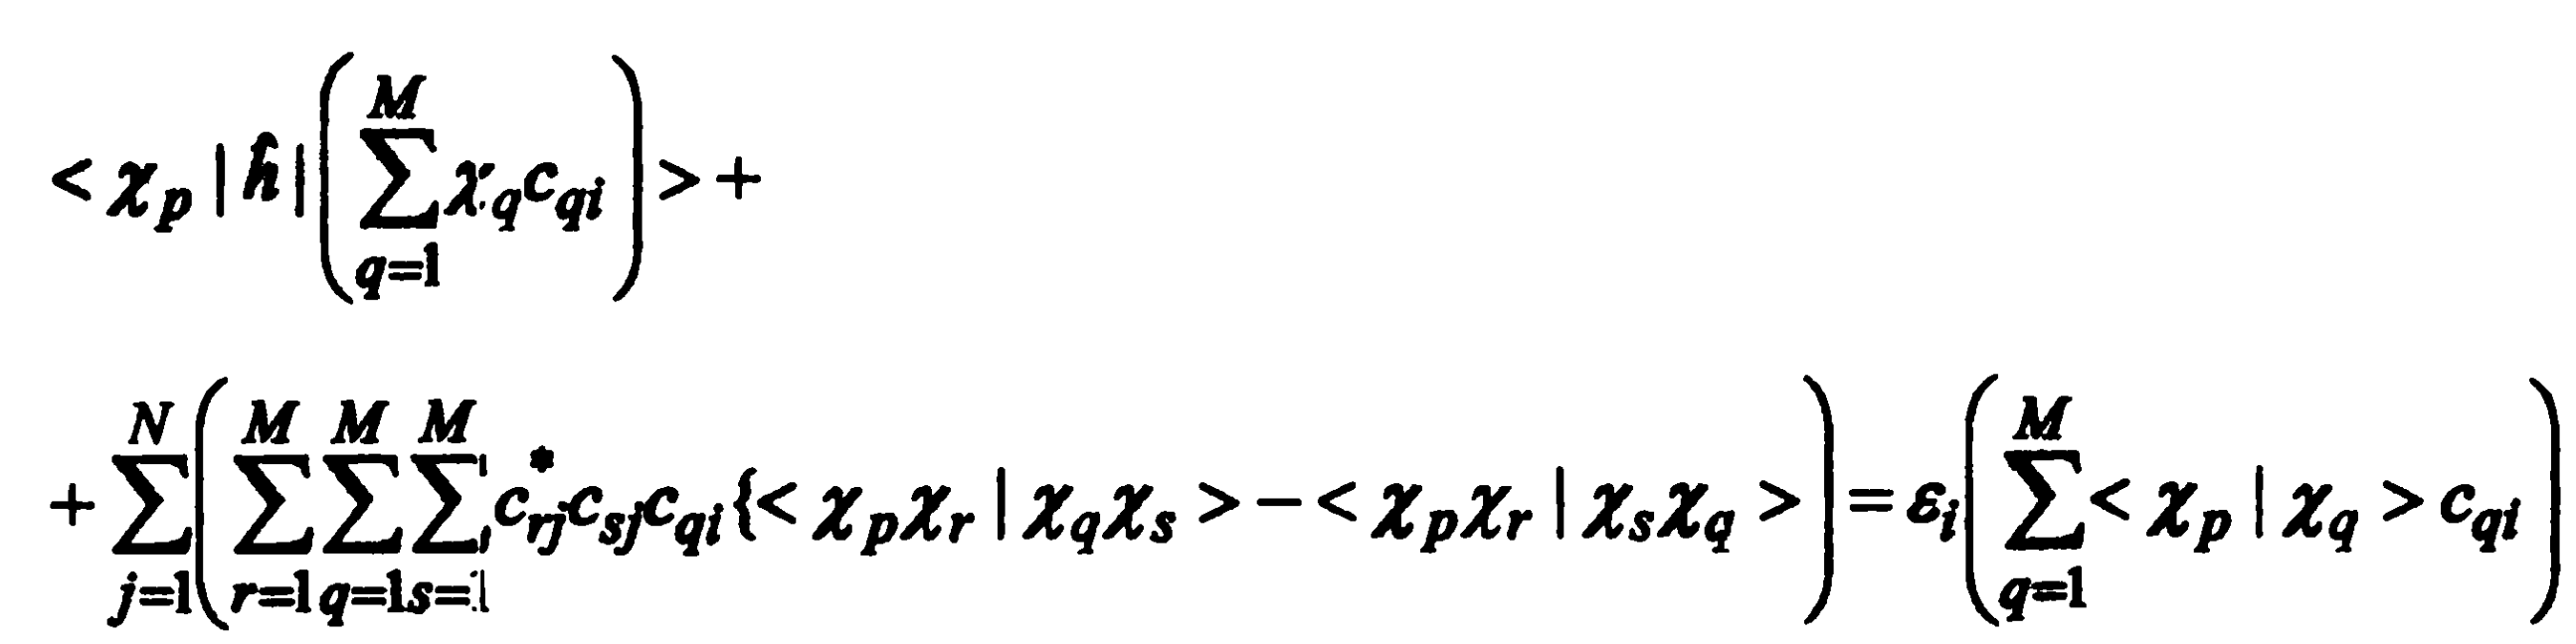

# What else we can extract from the HF method?

# Koopmans' theorem
In closed-shell Hartree-Fock theory, the first ionization energy of a molecular system is equal to the negative of the orbital energy of the highest occupied molecular orbital.

In [14]:
from pyscf import scf, gto

system = gto.M(atom = 'Ar 0 0 0', basis = 'aug-ccpvtz', spin=0)
HF = scf.RHF(system)
energy = HF.run()
HF.mo_energy

converged SCF energy = -526.813352167186


array([-118.6120703 ,  -12.32316431,   -9.57213597,   -9.57213597,
         -9.57213597,   -1.27788686,   -0.59136702,   -0.59136702,
         -0.59136702,    0.12975981,    0.12975981,    0.12975981,
          0.14535433,    0.40892145,    0.40892145,    0.40892145,
          0.40892145,    0.40892145,    0.71021613,    0.71021613,
          0.71021613,    1.06183256,    1.06183256,    1.06183256,
          1.06183256,    1.06183256,    1.06540278,    1.48701187,
          1.48701187,    1.48701187,    1.48701187,    1.48701187,
          1.48701187,    1.48701187,    2.90933913,    2.90933913,
          2.90933913,    2.90933913,    2.90933913,    3.03684259,
          3.03684259,    3.03684259,    3.78242899,    3.78242899,
          3.78242899,    3.78242899,    3.78242899,    3.78242899,
          3.78242899,    6.01212075])

# Experimental and calculated IE value of atoms (H-Xe)

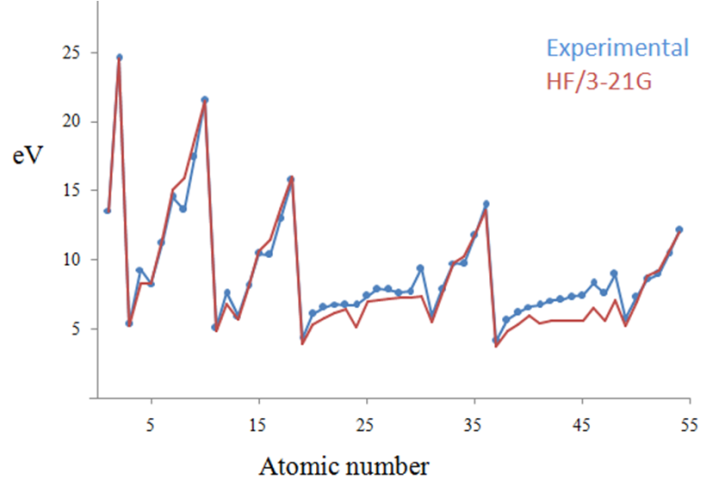